In [22]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
### matplotlib 한글설정(Mac) ###
# from matplotlib import rc
# %matplotlib inline
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False
#-----------------------------#

### matplotlib 한글설정(Ubuntu) ###
import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font]

import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothicCoding')

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
#-----------------------------#

from PIL import Image

from pycocotools.coco import COCO

In [23]:
json = '/USER/mnc/fish/data/labels/train.json'

coco = COCO(json)

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [24]:
coco.getCatIds()

[0, 1, 2, 3, 4, 5, 6, 7]

In [25]:
coco.loadCats(1)[0]['name']

'베스'

In [26]:
categories_info = {f"{coco.loadCats(i)[0]['name']}/{idx}": len(coco.getAnnIds(catIds=i)) for idx, i in enumerate(coco.getCatIds())}

print(f"{categories_info}\ntotal : {sum(categories_info.values())}")

{'농어/0': 180, '베스/1': 2344, '숭어/2': 651, '강준치/3': 2132, '블루길/4': 101, '잉어/5': 159, '붕어/6': 148, '누치/7': 586}
total : 6301


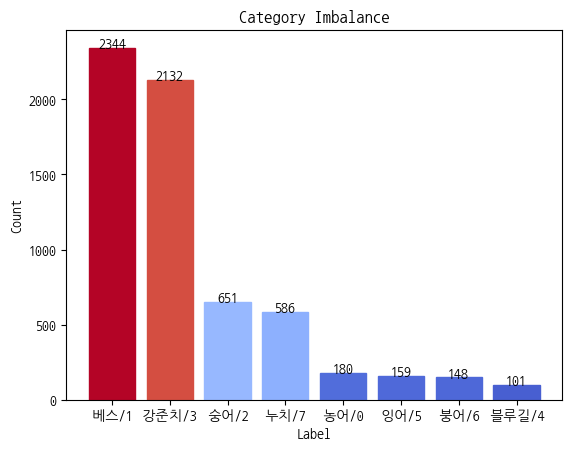

In [27]:
from collections import OrderedDict
import matplotlib.pyplot as plt

# 딕셔너리 데이터 정렬
visualize_dict = OrderedDict(sorted(categories_info.items(), key=lambda x: x[1], reverse=True))

# 딕셔너리의 키와 값을 추출
keys = list(visualize_dict.keys())
values = list(visualize_dict.values())

# 컬러맵 선택
cmap = plt.get_cmap('coolwarm')

# 바 그래프 생성
bars = plt.bar(keys, values)

# 컬러맵을 사용하여 바 그래프의 색상 설정
for bar, value in zip(bars, values):
    bar.set_color(cmap(value / max(values)) )

# 그래프에 레이블 추가
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.1, str(value), ha='center')

# 그래프 제목 및 레이블 설정
plt.title('Category Imbalance')
plt.xlabel('Label')
plt.ylabel('Count')

# 그래프 표시
plt.show()

## 블루길, 붕어, 잉어, 농어, 누치, 숭어 순으로 부족함.

- 이미지에 위 해당하는 물기가 단일로 찍혀있는 이미지가 있는지 확인.

- 숭어 / 누치 (2, 7)
    - approximately X 3



- 블루길 붕어 잉어 농어 (0, 4, 5, 6)
    - approximately X 20

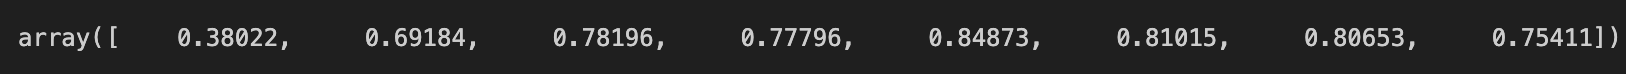

In [ ]:
# 농어가 가장 부정확함.
# 그 다음이 베스인데, label 수는 가장 많은데 두 번쨰로 부정확함.
# 다음으로 누치, 강준치, 숭어, 붕어, 잉어, 블루길

In [28]:
# 해당 카테고리에 해당하는 image_id
fish_cat = {
    '농어' : 0, 
    '베스' : 1, 
    '숭어': 2, 
    '강준치': 3, 
    '블루길': 4,
    '잉어': 5, 
    '붕어': 6, 
    '누치': 7, 
}

normal_cat = [fish_cat['베스'], fish_cat['강준치']]
low_cat   = [fish_cat['숭어'], fish_cat['누치']]
exlow_cat = [fish_cat['블루길'], fish_cat['붕어'], fish_cat['잉어'], fish_cat['농어']]

In [29]:
normal_cat_bass = coco.getImgIds(catIds=fish_cat['베스'])
normal_cat_gang = coco.getImgIds(catIds=fish_cat['강준치'])

low_cat_soong   = coco.getImgIds(catIds=fish_cat['숭어'])
low_cat_nu      = coco.getImgIds(catIds=fish_cat['누치'])

exlow_cat_blue  = coco.getImgIds(catIds=fish_cat['블루길'])
exlow_cat_bung  = coco.getImgIds(catIds=fish_cat['붕어'])
exlow_cat_ing   = coco.getImgIds(catIds=fish_cat['잉어'])
exlow_cat_nong  = coco.getImgIds(catIds=fish_cat['농어'])

img_id_list = [normal_cat_bass, normal_cat_gang, low_cat_soong, low_cat_nu, exlow_cat_blue, exlow_cat_bung, exlow_cat_ing, exlow_cat_nong]

In [ ]:
# for i in 


# low_cat_imglist = [coco.loadImgs()[0]['file_name'] for i in low_cat_list]
# exlow_cat_imglist = [coco.loadImgs(coco.getImgIds(catIds=i))[0]['file_name'] for i in exlow_cat_list]

In [ ]:
coco.getImgIds(catIds=1)

In [22]:
coco.loadImgs(90117)

[{'id': 90117,
  'width': 640,
  'height': 480,
  'file_name': 'train_63222.png',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0}]

# Crop fish bbox

In [30]:
all_img_id = coco.getImgIds()

coco.loadImgs(1)[0]

all_img_name = [coco.loadImgs(i)[0]['file_name'] for i in all_img_id]

In [31]:
print(all_img_id[:5], all_img_name[:5])

[1, 3, 4, 5, 6] ['train_0.png', 'train_1.png', 'train_2.png', 'train_3.png', 'train_4.png']


In [32]:
img_name_dict = {id: name for id, name in zip(all_img_id, all_img_name)}

In [33]:
all_label_info = []

for i in range(149821):
    try:
        all_info = coco.loadAnns(i)[0]
        img_id, bbox, cat = img_name_dict[all_info['image_id']], all_info['bbox'], all_info['category_id']
        all_label_info.append([img_id, cat, bbox])
    except:
        pass

In [34]:
all_label_info[:5]

[['train_0.png', 3, [37.98, 209.94, 369.19, 110.89]],
 ['train_185.png', 5, [57.07, 247.17, 384.16, 130.69]],
 ['train_186.png', 5, [96.59, 236.87, 427.01, 137.82]],
 ['train_192.png', 5, [154.41, 254.3, 467.41, 134.65]],
 ['train_194.png', 5, [26.18, 222.61, 409.5, 171.09]]]

In [35]:
fish_cat_folder = {
    0: 'exlow_nong', 
    1: 'normal_bass', 
    2: 'low_sung', 
    3: 'normal_gang', 
    4: 'exlow_blue', 
    5: 'exlow_ing', 
    6: 'exlow_bung', 
    7: 'low_nu', 
}

In [98]:
from PIL import Image
from tqdm import tqdm
"""
norm  [normal_bass, normal_gang]
low   [low_sung, low_nu]
exlow [exlow_blue, exlow_bung, exlow_ing, exlow_nong]
"""
train_img_dir = '/USER/mnc/fish/data/train/'
crop_img_dir  = '/USER/mnc/fish/data/crop/crop_fish/'

def crop_and_save_images(img_folder):

    for image_info in tqdm(img_folder):
        image_name = image_info[0]
        category = image_info[1]
        bbox = image_info[2]

        # 이미지 파일 로드
        image = Image.open(train_img_dir + image_name)
        
        # bbox 좌표 추출
        x, y, w, h = bbox
        x_min = x
        y_min = y
        x_max = x + w
        y_max = y + h
        
        # bbox 영역 crop
        cropped_image = image.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        try:
            full_crop_img_dir = crop_img_dir + fish_cat_folder[category]

            save_name = f"{full_crop_img_dir}/{image_name.split('.')[0]}.png"
            cropped_image.save(save_name)

        except:
            pass

# 함수 호출
crop_and_save_images(all_label_info)

100%|██████████| 6301/6301 [01:00<00:00, 104.92it/s]


In [70]:
# ms-coco의 bbox annotation은 yolo format으로 변환. 좌상단 x, y좌표, width, height 기반을 정규화된 center x,y 와 width, height로 변환. 
def bbox_2_yolo(bbox, img_w, img_h):
    # ms-coco는 좌상단 x, y좌표, width, height
    x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]

    # center x좌표는 좌상단 x좌표에서 width의 절반을 더함. center y좌표는 좌상단 y좌표에서 height의 절반을 더함. 
    centerx = bbox[0] + w / 2
    centery = bbox[1] + h / 2

    # centerx, centery, width, height를 이미지의 width/height로 정규화. 
    dw = 1 / img_w
    dh = 1 / img_h
    centerx *= dw
    w *= dw
    centery *= dh
    h *= dh

    return centerx, centery, w, h


bbox_2_yolo(bbox=[434, 111, 185, 78], img_w=640, img_h=480)

(0.8226562500000001, 0.3125, 0.2890625, 0.1625)

In [99]:
import random
from PIL import Image
import os

fish_cat = {
    'exlow_nong'  : 0, 
    'normal_bass' : 1, 
    'low_sung'    : 2, 
    'normal_gang' : 3, 
    'exlow_blue'  : 4,
    'exlow_ing'   : 5, 
    'exlow_bung'  : 6,
    'low_nu'      : 7
}

def composite_images(bg_dir, fish_label, create_cnt):

    crop_dir = '/USER/mnc/fish/data/crop/crop_fish/'
    output_dir = '/USER/mnc/fish/data/crop/output/'

    # background 폴더의 이미지 파일 목록 가져오기 (배경이미지들)
    bg_images = os.listdir(bg_dir)
    
    # 크롭된 물고기 이미지들
    fish_images = os.listdir(crop_dir + fish_label)


    cnt = 0
    while create_cnt:

        # 배경과 크롭 이미지 무작위 선택
        bg = random.choice(bg_images)
        crop_image_name = random.choice(fish_images)  # B 폴더의 crop된 이미지 파일 이름은 A 폴더의 이미지 파일 이름과 동일한 것으로 가정

        # bg 이미지 파일 경로 (배경이미지)
        bg_image_path = os.path.join(bg_dir, bg)

        # crop된 이미지 파일 경로 (물고기 크롭)
        crop_image_path = os.path.join(crop_dir, fish_label, crop_image_name)
        
        # bg 이미지 열기
        bg_image = Image.open(bg_image_path)
        bg_width, bg_height = bg_image.size
        
        # crop 이미지 열기
        crop_image = Image.open(crop_image_path)
        crop_width, crop_height = crop_image.size
        
        # bg 이미지 내에서 랜덤한 위치 계산
        max_x = bg_width - crop_width
        max_y = bg_height - crop_height
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)

        # xywh-format to YOLO-format(centerx, centery, w, h)
        xywh_bbox = [x, y, crop_width, crop_height]
        yolo_bbox = bbox_2_yolo(xywh_bbox, 640, 480)

        yolo_final = [fish_cat[fish_label], yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3]]

        # B 이미지를 A 이미지 위에 합성
        composite_image = Image.new('RGB', (640, 480), (250, 250, 250))
        composite_image.paste(bg_image, (0, 0))
        composite_image.paste(crop_image, (x, y))
        
        # 저장할 이미지 파일 경로
        output_image_path = os.path.join(output_dir, fish_label)
        
        # 합성된 이미지 저장
        composite_image.save(output_image_path + f'/{fish_label}_{cnt}.jpg')

        # save YOLO-format label.text
        with open(f'{output_image_path}/{fish_label}_{cnt}.txt', 'w+') as f:
            for i in yolo_final:
                f.write(f'{i} ')
       
        cnt += 1
        create_cnt -= 1
    

# 함수 호출
bg_dir = '/USER/mnc/fish/data/crop/crop_background/'

crop_folder_list = ['normal_bass', 'normal_gang', 'low_sung', 'low_nu', 'exlow_blue', 'exlow_bung', 'exlow_ing', 'exlow_nong']

for i in tqdm(crop_folder_list):
    composite_images(bg_dir=bg_dir, fish_label=i, create_cnt=2500)

100%|██████████| 8/8 [04:06<00:00, 30.75s/it]


In [77]:
### ------------------------------------------------- ###
### ----------- 해당 폴더 내 모든 파일 삭제 ----------- ###
### ------------------------------------------------- ###

# remove_dir = '/USER/mnc/fish/data/crop/crop_fish/'
# remove_dir = '/USER/mnc/fish/data/crop/output/'
remove_dir = '/USER/mnc/fish/data/mixup/'

crop_folder_list = ['normal_bass', 'normal_gang', 'low_sung', 'low_nu', 'exlow_blue', 'exlow_bung', 'exlow_ing', 'exlow_nong']

def DeleteAllFiles(filePath):
    if os.path.exists(filePath):
        for file in os.scandir(filePath):
            os.remove(file.path)
        return 'Remove All File'
    else:
        return 'Directory Not Found'

for i in crop_folder_list:
    DeleteAllFiles(remove_dir + i)

### ------------------------------------------------- ###
### ------------------------------------------------- ###
### ------------------------------------------------- ###

# Mix-up

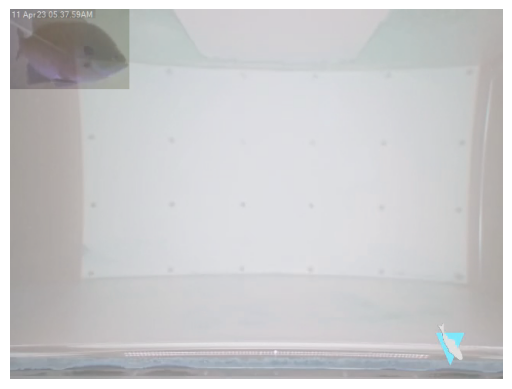

In [63]:
import torchvision
import requests
from PIL import Image
import io
import numpy as np
import cv2
import matplotlib.pyplot as plt

bg_img   = cv2.imread("/USER/mnc/fish/data/crop/crop_background/train_15.png")
fish_img = Image.open("/USER/mnc/fish/data/crop/crop_fish/exlow_blue/train_13319.png")


# Create fish image with 640x480
composite_img = Image.new('RGB', (640, 480), (250, 250, 250))
composite_img.paste(fish_img, (0, 0))
composite_img = np.array(composite_img)

def mixup(x1, x2, y1, y2, lambda_=0.5):
    # 믹스업 할 때 공식, 논문에 그대로 나온다.
    x = lambda_ * x1 + (1-lambda_) * x2 
    y = lambda_ * y1 + (1-lambda_) * y2
    return x, y

x, y = mixup(bg_img, composite_img, np.array([1,0]), np.array([0,1]), lambda_=0.5)

plt.axis('off')
plt.imshow(x.astype(int)), y
plt.show()
# np.array에서 첫번째 = cat label, 두번째(0) = dog label

# cv2.COLOR_BGR2RGB를 하지 않으면 색상이 이상하게 나온다.
# cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
# cv2.imshow("Test", cat_img)
# cv2.waitKey(0)

In [78]:
import random
from PIL import Image
import os
from tqdm import tqdm

fish_cat = {
    'exlow_nong'  : 0, 
    'normal_bass' : 1, 
    'low_sung'    : 2, 
    'normal_gang' : 3, 
    'exlow_blue'  : 4,
    'exlow_ing'   : 5, 
    'exlow_bung'  : 6,
    'low_nu'      : 7
}

def mixup(x1, x2, y1, y2, lambda_=0.5):
    # 믹스업 할 때 공식, 논문에 그대로 나온다.
    x = lambda_ * x1 + (1-lambda_) * x2 
    y = lambda_ * y1 + (1-lambda_) * y2
    return x, y

def composite_images(
                     fish_label, create_cnt, 
                     bg_dir           = '/USER/mnc/fish/data/crop/crop_background/', 
                     crop_dir         = '/USER/mnc/fish/data/crop/crop_fish/', 
                     crop_folder_list = ['normal_bass', 'normal_gang', 'low_sung', 'low_nu', 'exlow_blue', 'exlow_bung', 'exlow_ing', 'exlow_nong'], 
                     output_dir       = '/USER/mnc/fish/data/crop/output/', 
                    ):
    
    # background 폴더의 이미지 파일 목록 가져오기 (배경이미지들)
    bg_images = os.listdir(bg_dir)
    
    # 크롭된 물고기 이미지들
    fish_images = os.listdir(crop_dir + fish_label)


    cnt = 0
    while create_cnt:

        # 배경과 크롭 이미지 무작위 선택
        bg = random.choice(bg_images)
        crop_image_name = random.choice(fish_images)  # B 폴더의 crop된 이미지 파일 이름은 A 폴더의 이미지 파일 이름과 동일한 것으로 가정

        # bg 이미지 파일 경로 (배경이미지)
        bg_image_path = os.path.join(bg_dir, bg)

        # crop된 이미지 파일 경로 (물고기 크롭)
        crop_image_path = os.path.join(crop_dir, fish_label, crop_image_name)
        
        # bg 이미지 열기
        bg_image = Image.open(bg_image_path)
        bg_width, bg_height = bg_image.size
        
        # crop 이미지 열기
        crop_image = Image.open(crop_image_path)
        crop_width, crop_height = crop_image.size
        
        # bg 이미지 내에서 랜덤한 위치 계산
        max_x = bg_width - crop_width
        max_y = bg_height - crop_height
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)

        # xywh-format to YOLO-format(centerx, centery, w, h)
        xywh_bbox = [x, y, crop_width, crop_height]
        yolo_bbox = bbox_2_yolo(xywh_bbox, 640, 480)

        yolo_final = [fish_cat[fish_label], yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3]]

        # B 이미지를 A 이미지 위에 합성
        composite_image = Image.new('RGB', (640, 480), (250, 250, 250))
        # composite_image.paste(bg_image, (0, 0))
        composite_image.paste(crop_image, (x, y))
        
        # mixup을 위해 PIL로 읽어온 이미지를 array형태로 변환
        bg_image        = np.array(bg_image)
        composite_image = np.array(composite_image)
        
        # 배경과 crop된 물고기 이미지를 mixup
        x, y = mixup(bg_image, composite_image, np.array([1,0]), np.array([0,1]), lambda_=0.5)
        
        # array형태로 바뀌어 있는 이미지를 다시 PIL 이미지로
        x = Image.fromarray(x.astype(np.uint8))
        
        
        # 저장할 이미지 파일 경로
        output_image_path = os.path.join(output_dir, fish_label)
        
        # 합성된 이미지 저장
        # composite_image.save(output_image_path + f'/{fish_label}_{cnt}.jpg')
        x.save(output_image_path + f'/{fish_label}_{cnt}.jpg')

        # save YOLO-format label.text
        with open(f'{output_image_path}/{fish_label}_{cnt}.txt', 'w+') as f:
            for i in yolo_final:
                f.write(f'{i} ')
       
        cnt += 1
        create_cnt -= 1
    

# 함수 호출
# crop_folder_list = ['normal_bass', 'normal_gang', 'low_sung', 'low_nu', 'exlow_blue', 'exlow_bung', 'exlow_ing', 'exlow_nong']
crop_folder_list = ['normal_bass', 'exlow_nong']

for i in tqdm(crop_folder_list):
    if i == 'exlow_nong':
        image_num = 2000
    else:
        image_num = 500
    composite_images(fish_label=i, create_cnt=image_num, output_dir='/USER/mnc/fish/data/mixup/')

100%|██████████| 2/2 [00:39<00:00, 19.71s/it]


In [81]:
from glob import glob

# 전체 train data의 경로를 가지고있는 txt파일 + 위에서 추가로 생성한 이미지들의 경로를 가진 txt파일을 합쳐야함.
crop_train = '/USER/mnc/fish/data/YOLO/crop_stratified/train.txt'

add_image_list = []
crop_folder_list = ['normal_bass', 'exlow_nong']
for i in crop_folder_list:
    add_image_list.append(glob(f'/USER/mnc/fish/data/mixup/{i}/*.jpg'))
    
add_image_list = sum(add_image_list, [])
len(add_image_list)

2500

In [82]:
with open('/USER/mnc/fish/data/mixup/train.txt', 'a') as f:
    for i in add_image_list:
        f.write(f'{i}\n')

2500

# YOLO train / test 합치기


In [90]:
from glob import glob
import os
import shutil

with open('/USER/mnc/fish/data/mixup/train.txt', 'w+') as f:
    for i in add_image_list:
        f.write(f'{i}\n')
        
with open('/USER/mnc/fish/data/mixup/train.txt', 'a') as f:
    for i in glob(f'/USER/mnc/fish/data/yolo_train_test_stratified/train/*.png'):
        f.write(f'{i}\n')

[]

# Train-Test-Split (Stratified)

In [134]:
# 크롭된 모든 이미지들의 경로정보를 가진 .txt파일 만들기

crop_dir         = '/USER/mnc/fish/data/crop/output/'
crop_folder_list = ['exlow_nong', 'normal_bass', 'low_sung', 'normal_gang', 'exlow_blue', 'exlow_ing', 'exlow_bung', 'low_nu']

with open(f'{crop_dir}all_data.txt', 'w+') as f:
    for folder in tqdm(crop_folder_list):
        img_list = os.listdir(crop_dir + folder)
        for img in img_list:
            if img[-3:] == 'txt':
                continue
            f.write(f'{crop_dir}{folder}/{img}\n')

fish_cat = {
    'exlow_nong'  : 0, 
    'normal_bass' : 1, 
    'low_sung'    : 2, 
    'normal_gang' : 3, 
    'exlow_blue'  : 4,
    'exlow_ing'   : 5, 
    'exlow_bung'  : 6,
    'low_nu'      : 7
}
labels = []

for i in crop_folder_list:
    for _ in range(2500):
        labels.append(fish_cat[i])

100%|██████████| 8/8 [00:00<00:00, 203.69it/s]


In [ ]:
data_list = []

with open('/USER/mnc/fish/data/crop/output/all_data.txt', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        data_list.append(line.strip())

In [141]:
from sklearn.model_selection import train_test_split

data  = data_list
label = labels

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=2023)

In [150]:
with open('/USER/mnc/fish/data/YOLO/crop_stratified/train/train.txt', 'w+') as f:
    for line in X_train:
        f.write(f'{line}\n')
    
with open('/USER/mnc/fish/data/YOLO/crop_stratified/test/test.txt', 'w+') as f:
    for line in X_test:
        f.write(f'{line}\n')

# Create YOLO-format label.txt from train_data

In [156]:
from glob import glob

'/USER/mnc/fish/data/yolo_train_test_stratified/test'
'/USER/mnc/fish/data/yolo_train_test_stratified/train'


len(glob('/USER/mnc/fish/data/yolo_train_test_stratified/train/*.png')), len(glob('/USER/mnc/fish/data/yolo_train_test_stratified/test/*.png'))

(4684, 1169)

In [153]:
json = '/USER/mnc/fish/data/labels/train.json'

coco = COCO(json)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [8]:
# image_id로 file_name 찾기
coco.loadImgs(90117)

[{'id': 90117,
  'width': 640,
  'height': 480,
  'file_name': 'train_63222.png',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0}]

In [9]:
# image_id로 annotaion_id 찾기
coco.getAnnIds(imgIds=90117)

[4761]

In [10]:
# annotation_id로 해당 annotation정보 찾기
coco.loadAnns(4761)

[{'id': 4761,
  'image_id': 90117,
  'category_id': 1,
  'segmentation': [],
  'area': 15675.597999999996,
  'bbox': [272.99, 287.36, 173.98, 90.1],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

In [11]:
coco.loadAnns(4761)

[{'id': 4761,
  'image_id': 90117,
  'category_id': 1,
  'segmentation': [],
  'area': 15675.597999999996,
  'bbox': [272.99, 287.36, 173.98, 90.1],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

test_bbox_img = Image.open(test_png_list[0])

bbox_my = my_dict['test_0.png'][0][2]
bbox_dh = dh_dict['test_0.png'][0][2]

# 이미지를 Matplotlib로 표시
plt.imshow(test_bbox_img)

# bounding box 정보 추출 및 시각화

bbox_1 = bbox_my
bbox_2 = bbox_dh
category_id = "test"

# COCO annotation에서 (x, y, width, height) 형태를 (x, y, x+width, y+height)로 변환
x_1, y_1, width_1, height_1 = bbox_1
x_2, y_2, width_2, height_2 = bbox_2
# x, y, x2, y2 = x, y, x + width, y + height

# bounding box를 시각화
rect_1 = patches.Rectangle((x_1, y_1), width_1, height_1, linewidth=2, edgecolor="r", facecolor="none", label=f"Category {category_id}")
rect_2 = patches.Rectangle((x_2, y_2), width_2, height_2, linewidth=2, edgecolor="b", facecolor="none", label=f"Category {category_id}")
plt.gca().add_patch(rect_1)
plt.gca().add_patch(rect_2)

plt.show()


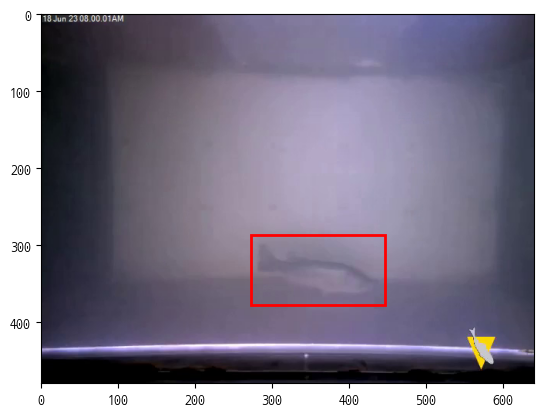

In [14]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

test_bbox_img = Image.open(cwd + "train/train_63222.png")

bbox_data = coco.loadAnns(4761)[0]['bbox']

# 이미지를 Matplotlib로 표시
plt.imshow(test_bbox_img)

# bounding box 정보 추출 및 시각화

bbox = bbox_data
category_id = "test"

# COCO annotation에서 (x, y, width, height) 형태를 (x, y, x+width, y+height)로 변환
x, y, width, height = bbox
# x, y, x2, y2 = x, y, x + width, y + height

# bounding box를 시각화
rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor="r", facecolor="none", label=f"Category {category_id}")
plt.gca().add_patch(rect)

plt.show()

In [7]:
# Category ID check
coco.getCatIds()

# find annotation ID of image_id
coco.getAnnIds(imgIds=1)
# find annotation ID of category_id
coco.getAnnIds(catIds=1)

# find Image ID of category_id
coco.getImgIds(catIds=1)

# Specific data of category_id
coco.loadCats(1)

# All specific annotation dict data of annotation_id
coco.loadAnns(1)

# All specific image dict data of image_id
coco.loadImgs(1)

[{'id': 1,
  'width': 640,
  'height': 480,
  'file_name': 'train_0.png',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0}]

In [8]:
coco.loadAnns(1)

[{'id': 1,
  'image_id': 1,
  'category_id': 3,
  'segmentation': [],
  'area': 40939.4791,
  'bbox': [37.98, 209.94, 369.19, 110.89],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

In [9]:
coco.loadImgs(1)

[{'id': 1,
  'width': 640,
  'height': 480,
  'file_name': 'train_0.png',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0}]

In [17]:
coco.loadCats(1)[0]['name']

'베스'

In [18]:
categories_info = {coco.loadCats(i)[0]['name']: len(coco.getAnnIds(catIds=i)) for i in coco.getCatIds()}

print(f"{categories_info}\ntotal : {sum(categories_info.values())}")

{'농어': 180, '베스': 2344, '숭어': 651, '강준치': 2132, '블루길': 101, '잉어': 159, '붕어': 148, '누치': 586}
total : 6301


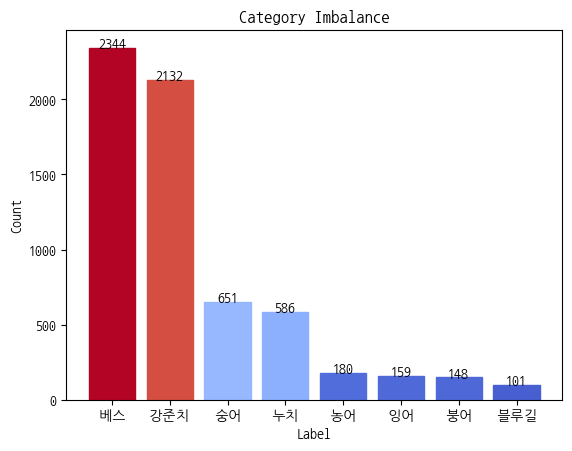

In [19]:
from collections import OrderedDict
import matplotlib.pyplot as plt

# 딕셔너리 데이터 정렬
visualize_dict = OrderedDict(sorted(categories_info.items(), key=lambda x: x[1], reverse=True))

# 딕셔너리의 키와 값을 추출
keys = list(visualize_dict.keys())
values = list(visualize_dict.values())

# 컬러맵 선택
cmap = plt.get_cmap('coolwarm')

# 바 그래프 생성
bars = plt.bar(keys, values)

# 컬러맵을 사용하여 바 그래프의 색상 설정
for bar, value in zip(bars, values):
    bar.set_color(cmap(value / max(values)) )

# 그래프에 레이블 추가
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.1, str(value), ha='center')

# 그래프 제목 및 레이블 설정
plt.title('Category Imbalance')
plt.xlabel('Label')
plt.ylabel('Count')

# 그래프 표시
plt.show()

In [26]:
categories_info = {coco.loadCats(i)[0]['name']: len(coco.getAnnIds(catIds=i)) for i in coco.getCatIds()}

print(f"{categories_info}\ntotal : {sum(categories_info.values())}")

# Create list of cat_0 ~ cat_7 image name.
for i in range(8):
    globals()[f"cat_{i}_list"] = ["train_" + str(i) + ".png" for i in coco.getAnnIds(catIds=i)]

len(cat_0_list), len(cat_1_list)

{'농어': 180, '베스': 2344, '숭어': 651, '강준치': 2132, '블루길': 101, '잉어': 159, '붕어': 148, '누치': 586}
total : 6301


(180, 2344)

In [43]:
cat_0_list[:10]

['train_371.png',
 'train_372.png',
 'train_373.png',
 'train_375.png',
 'train_417.png',
 'train_432.png',
 'train_459.png',
 'train_461.png',
 'train_527.png',
 'train_531.png']

In [27]:
import os
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, clear_output

# 이미지 파일이 있는 디렉토리 경로 설정
image_dir = train_dir  # 이미지 파일이 있는 디렉토리 경로를 지정합니다.
# image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
image_files = cat_2_list

# 이미지 파일을 하나씩 순회
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    img = Image.open(image_path)
    
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("root/anaconda3/envs/fish/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/NanumGothic.ttf", 30)
    draw.text((250, 5), image_file, fill='red', font=font)
    
    display(img)

    # 사용자의 입력을 기다립니다.
    user_input = input("Press Enter to open the next image, or 'q' to quit...")

    # 이미지를 닫습니다.
    clear_output()

    # 사용자가 'q'를 누르면 루프를 종료합니다.
    if user_input.lower() == 'q':
        break

NameError: name 'cat_2_list' is not defined

In [44]:
len(train_list), len(test_list)

(104875, 44946)

In [ ]:
python main.py --path <Absolute path to dataset_root_dir> --output <Name of the json file>

python main.py --path <Absolute path to dataset_root_dir> --output /USER/mnc/fish/outputs/YOLO/YOLOtoCOCO_test.json

In [ ]:
mnc/fish/data/yolo_train


# Image similarity

- histogram기반 유사도 측정

In [1]:
import cv2
import numpy as np

def compare_images(image1_path, image2_path):
    # 이미지 불러오기
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    # 이미지 크기 조정
    image1 = cv2.resize(image1, (300, 300))
    image2 = cv2.resize(image2, (300, 300))

    # 이미지를 그레이스케일로 변환
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # 히스토그램 계산
    hist1 = cv2.calcHist([image1_gray], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([image2_gray], [0], None, [256], [0, 256])

    # 히스토그램 비교
    similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

    return similarity

image1_path = '/USER/mnc/fish/data/crop/crop_background/train_23242.png'
image2_path = '/USER/mnc/fish/data/crop/crop_background/train_50152.png'

similarity_score = compare_images(image1_path, image2_path)
print(f"두 이미지의 유사도: {similarity_score}")


두 이미지의 유사도: 0.6393574674292233


비교 알고리즘

​

1. cv2.HISTCMP_CORREL : 상관관계

    1: 완전 일치, -1: 완전 불일치, 0: 무관계

    빠르지만 부정확

​

2. cv2.HISTCMP_CHISQR : 카이제곱 검정(Chi-Squared Test)

    0: 완전 일치, 무한대: 완전 불일치

​

3. cv2.HISTCMP_INTERSECT : 교차

    1: 완전 일치, 0: 완전 불일치(히스토그램이 1로 정규화된 경우)

​

4. cv2.HISTCMP_BHATTACHARYYA : 바타차야 거리

    0: 완전 일치, 1: 완전 불일치

    느리지만 가장 정확

​

5. EMD

    직관적이지만 가장 느림

In [16]:
import cv2
import numpy as np
import matplotlib.pylab as plt

image1_path = '/USER/mnc/fish/data/crop/crop_background/train_19734.png'
# image2_path = '/USER/mnc/fish/data/crop/crop_background/train_19734.png'
image2_path = '/USER/mnc/fish/data/crop/crop_background/train_19784.png'

# 이미지 읽어오기
imgs = []
imgs.append(cv2.imread(image1_path))
imgs.append(cv2.imread(image2_path))

hists = []
for img in imgs:
    # BGR 이미지를 HSV 이미지로 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # 히스토그램 연산(파라미터 순서 : 이미지, 채널, Mask, 크기, 범위)
    hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
    # 정규화(파라미터 순서 : 정규화 전 데이터, 정규화 후 데이터, 시작 범위, 끝 범위, 정규화 알고리즘)
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    # hists 리스트에 저장
    hists.append(hist)

# 1번째 이미지를 원본으로 지정
query = hists[0]

# 비교 알고리즘의 이름들을 리스트에 저장
methods = ['CORREL', 'CHISQR', 'INTERSECT', 'BHATTACHARYYA', 'EMD']

# 5회 반복(5개 비교 알고리즘을 모두 사용)
for index, name in enumerate(methods):
    # 비교 알고리즘 이름 출력(문자열 포맷팅 및 탭 적용)
    print('%-10s' % name, end = '\t')  
    
    # 2회 반복(2장의 이미지에 대해 비교 연산 적용)
    for i, histogram in enumerate(hists):
        ret = cv2.compareHist(query, histogram, index) 
        
        if index == cv2.HISTCMP_INTERSECT:                   # 교차 분석인 경우 
            ret = ret/np.sum(query)                          # 원본으로 나누어 1로 정규화
            
        print("img%d :%7.2f"% (i+1 , ret), end='\t')         # 비교 결과 출력

    print()    

CORREL    	img1 :   1.00	img2 :   0.32	
CHISQR    	img1 :   0.00	img2 :3804.13	
INTERSECT 	img1 :   1.00	img2 :   0.28	
BHATTACHARYYA	img1 :   0.00	img2 :   0.71	
EMD       	img1 :   0.00	img2 : 317.90	


In [15]:
import cv2
import numpy as np
import matplotlib.pylab as plt

image1_path = '/USER/mnc/fish/data/crop/crop_background/train_19734.png'
image2_path = '/USER/mnc/fish/data/crop/crop_background/train_19734.png'
# image2_path = '/USER/mnc/fish/data/crop/crop_background/train_19784.png'


imgs = []
imgs.append(cv2.imread(image1_path))
imgs.append(cv2.imread(image2_path))

hists = []

for img in imgs:
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX) 
    hists.append(hist)

# 원하는 비교 알고리즘 index 선택
# method = ['CORREL', 'CHISQR', 'INTERSECT', 'BHATTACHARYYA', 'EMD']
method = 1


query = hists[0]
ret = cv2.compareHist(query, hists[1], method)

if method == cv2.HISTCMP_INTERSECT:
    ret = ret/np.sum(query)   

if ret == 1:
    print('Same Image')
else:
    print('Different Image')

Different Image


# Faiss 기반 이미지 유사도 측정

In [21]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1166248934757610404
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14298316800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9966820111896392894
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:18:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available:  1


2023-11-13 02:30:02.750552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 13635 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:18:00.0, compute capability: 7.5
